In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

# ARIMA(p, d, q) Order Selection Demo

This notebook simulates four synthetic series:
- AR(1)
- MA(2)
- ARMA(1,1)
- ARIMA(2,1,1)

For each series we
1. Plot it  
2. Run the Augmented Dickey–Fuller (ADF) test → choose `d`  
3. Plot ACF & PACF (of differenced series if `d=1`)  
4. Grid‐search small `(p, d, q)` and pick the model with lowest AIC  

In [3]:
# We generate a synthetic time series data using AR(1), MA(2), ARMA(1, 1) and an ARIMA(2, 1, 1) model
n = 500
date_idx = pd.date_range('2000-01-01', periods=n, freq='D')

# 1) AR(1): phi=0.6
ar1 = np.array([1, -0.6]); ma1 = np.array([1])
ts_ar1 = pd.Series(ArmaProcess(ar1, ma1).generate_sample(nsample=n), index=date_idx)

# 2) MA(2): theta1=0.5, theta2=-0.3
ar2 = np.array([1]); ma2 = np.array([1, 0.5, -0.3])
ts_ma2 = pd.Series(ArmaProcess(ar2, ma2).generate_sample(nsample=n), index=date_idx)

# 3) ARMA(1,1): phi=0.6, theta=0.5
ar3 = np.array([1, -0.6]); ma3 = np.array([1, 0.5])
ts_arma11 = pd.Series(ArmaProcess(ar3, ma3).generate_sample(nsample=n), index=date_idx)

# 4) ARIMA(2,1,1): AR phi1=0.5, phi2=0.2; MA theta=0.4
ar4 = np.array([1, -0.5, -0.2]); ma4 = np.array([1, 0.4])
ts_temp = pd.Series(ArmaProcess(ar4, ma4).generate_sample(nsample=n), index=date_idx)
ts_arima211 = ts_temp.cumsum()  # integrate once

series_dict = {
    "AR(1)": ts_ar1,
    "MA(2)": ts_ma2,
    "ARMA(1,1)": ts_arma11,
    "ARIMA(2,1,1)": ts_arima211
}

## Stationarity

A **stationary** time series has statistical properties (mean, variance, autocovariance) that do not change over time.  
- **Strict stationarity**: the entire joint distribution is invariant under time‐shifts.  
- **Weak (covariance) stationarity**: the mean is constant, the variance is finite and constant, and the autocovariance depends only on lag, not time.  

Why it matters: 
- Many time‐series methods (ARMA, ARIMA, Kalman filters, GARCH, etc.) assume stationarity.  
- Non‐stationary data can give spurious regressions, unstable forecasts, misleading inference.  

Reality check in finance:
- Most asset‐price series (stocks, FX, commodities, indices) are **non‐stationary** (unit roots, trending, heteroskedastic).
- Even returns can exhibit time‐varying volatility (ARCH/GARCH effects).  
- Truly stationary financial series are **rare**; one typically needs differencing, detrending, de‐seasonalizing or volatility modeling before applying classical linear‐stationary models.

In [4]:
def test_stationarity(ts, name):
    print(f"\n--- Stationarity Tests for {name} ---")
    ts_clean = ts.dropna()

    # ADF: H0 = non-stationary (unit root)
    adf_stat, adf_p, _, _, adf_crits, _ = adfuller(ts_clean)
    print(f"ADF    stat = {adf_stat:.3f}, p-value = {adf_p:.3f}")
    for level, crit in adf_crits.items():
        print(f"   {level} crit: {crit:.3f}")
    print("→ ADF " + ("reject H0 (stationary)" if adf_p < 0.05 else "fail to reject H0 (non-stationary)"))

    # KPSS: H0 = stationary
    kpss_stat, kpss_p, _, kpss_crits = kpss(ts_clean, nlags="auto")
    print(f"KPSS   stat = {kpss_stat:.3f}, p-value = {kpss_p:.3f}")
    for level, crit in kpss_crits.items():
        print(f"   {level} crit: {crit:.3f}")
    print("→ KPSS " + ("fail to reject H0 (stationary)" if kpss_p > 0.05 else "reject H0 (non-stationary)"))

# Run stationarity tests on each simulated series
for name, ts in series_dict.items():
    test_stationarity(ts, name)


--- Stationarity Tests for AR(1) ---
ADF    stat = -11.299, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.141, p-value = 0.100
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for MA(2) ---
ADF    stat = -6.487, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.366, p-value = 0.092
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for ARMA(1,1) ---
ADF    stat = -8.007, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.160, p-value = 0.100
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for ARIMA(2,1,1) ---
ADF    stat

## Interpretation

- **AR(1)** → stationary (ADF & KPSS both say stationary), PACF cuts at lag 1 → AR(1).  
- **MA(2)** → stationary, ACF cuts at lag 2 → MA(2).  
- **ARMA(1,1)** → stationary, both ACF & PACF tail off → ARMA(1,1).  
- **ARIMA(2,1,1)** → non‐stationary (ADF fail, KPSS reject), first‐difference (thus, $d = 1$) becomes stationary, ACF/PACF of the differenced series suggest ARMA(2, 1) → ARIMA(2, 1, 1).

Note: **ALL** ARMA(p, q) processes are stationary.

Most real-world financial price series are non-stationary; you almost always must difference (or detrend) before fitting an ARMA-type model.

## Time‐Series Model Definitions

Below are the standard definitions of AR, MA, ARMA and ARIMA processes.  We use the back‐shift operator $B$, where $B X_t = X_{t-1}$, and $\{\varepsilon_t\}$ denotes a white‐noise sequence (zero mean, constant variance $\sigma^2$).

---

### AutoRegressive AR(p)

An AR(p) process satisfies
$$
  X_t \;=\; \phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p} \;+\; \varepsilon_t
$$
or, in operator form,
$$
  \phi(B)\,X_t \;=\;\varepsilon_t,
  \quad
  \phi(B) = 1 - \phi_1 B - \cdots - \phi_p B^p.
$$

---

### Moving‐Average MA(q)

An MA(q) process satisfies
$$
  X_t \;=\; \mu \;+\; \varepsilon_t \;+\; \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q}
$$
or
$$
  X_t - \mu \;=\; \theta(B)\,\varepsilon_t,
  \quad
  \theta(B) = 1 + \theta_1 B + \cdots + \theta_q B^q.
$$

---

### ARMA(p, q)

An ARMA(p, q) process combines both AR and MA terms:
$$
  X_t
  \;=\;
  \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p}
  \;+\;
  \varepsilon_t
  \;+\;
  \theta_1\varepsilon_{t-1} + \cdots + \theta_q\varepsilon_{t-q},
$$
or
$$
  \phi(B)\,X_t \;=\; \theta(B)\,\varepsilon_t.
$$

---

### ARIMA(p, d, q)

An ARIMA(p, d, q) process applies an ARMA(p, q) model to the \(d\)th difference of \(X_t\).  Let
$$
  \nabla^d X_t \;=\;(1 - B)^d X_t.
$$
Then
$$
  \phi(B)\,\bigl((1 - B)^d X_t\bigr)
  \;=\;
  \theta(B)\,\varepsilon_t,
$$
i.e.
$$
  (1 - \phi_1 B - \cdots - \phi_p B^p)\,(1 - B)^d X_t
  \;=\;
  (1 + \theta_1 B + \cdots + \theta_q B^q)\,\varepsilon_t.
$$

## Practical ARIMA Order-Selection Workflow

1. Test for stationarity → determine $d$  
   - Run unit‐root tests (ADF, KPSS) on the raw series.  
   - If non‐stationary, difference once  
     $$
       \Delta X_t = X_t - X_{t-1}
     $$  
     and retest.  
   - Continue until stationarity is achieved (this gives you $d$).

2. Inspect ACF & PACF → get a rough idea of $p$ and $q$  
   - Plot the ACF and PACF of the (differenced) stationary series.  
   - PACF “cuts off” after lag $p$ ⇒ candidate AR($p$).  
   - ACF “cuts off” after lag $q$ ⇒ candidate MA($q$).  
   - If neither cuts off cleanly, expect an ARMA($p,q$). Usually PACF cut‐offs are more reliable than ACF cut‐offs, so selecting $p$ may be easier than selecting $q$.

3. Grid‐search over $(p,d,q)$ → refine your choice  
   - There is **no single “standard”** method for choosing $p,q$.  
   - Use your ACF/PACF insights to limit the search range (e.g. $p,q \le 3$ or 5). **Why do we want to limit the search range?**
   - Fit ARIMA models over that grid and compare information criteria (AIC/BIC).  
   - Check residual diagnostics (Ljung–Box, residual ACF, homoskedasticity, normality).

4. Validate & iterate  
   - Re-examine model residuals—no autocorrelation, constant variance, roughly normal.  
   - If diagnostics fail, adjust $p$ or $q$ (or reconsider $d$).  
   - Optionally include trend or seasonal terms if needed.

**Key point:**  
You generally start with stationarity (fixing $d$) → use ACF/PACF as a **rule of thumb** to pick $p,q$ → then iterate by fitting and comparing candidate models. There is no “perfect” algorithmic shortcut—experience and diagnostic checks steer you to a robust final model.

In [5]:
# TODO: Conduct steps 1, 2, 3 and 4 for each time series in
'''
series_dict = {
    "AR(1)": ts_ar1,
    "MA(2)": ts_ma2,
    "ARMA(1,1)": ts_arma11,
    "ARIMA(2,1,1)": ts_arima211
}
'''
# The residual series should resemble a white noise (which is stronger than stationartiy). 
# For the case of mean-reverting series, we only care about the stationarity.

'\nseries_dict = {\n    "AR(1)": ts_ar1,\n    "MA(2)": ts_ma2,\n    "ARMA(1,1)": ts_arma11,\n    "ARIMA(2,1,1)": ts_arima211\n}\n'

# Step 1

In [6]:
for name, ts in series_dict.items():
    test_stationarity(ts, name)


--- Stationarity Tests for AR(1) ---
ADF    stat = -11.299, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.141, p-value = 0.100
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for MA(2) ---
ADF    stat = -6.487, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.366, p-value = 0.092
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for ARMA(1,1) ---
ADF    stat = -8.007, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.160, p-value = 0.100
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for ARIMA(2,1,1) ---
ADF    stat

In [7]:
series_dict_diff = {}
d_values = {}

for name, ts in series_dict.items():
    adf_p = adfuller(ts.dropna())[1]
    
    if adf_p < 0.05:
        # 정상 → 차분 불필요
        series_dict_diff[name] = ts
        d_values[name] = 0
    else:
        # 비정상 → 1차 차분
        series_dict_diff[name] = ts.diff().dropna()
        d_values[name] = 1

print("d_values:", d_values)

d_values: {'AR(1)': 0, 'MA(2)': 0, 'ARMA(1,1)': 0, 'ARIMA(2,1,1)': 1}


In [8]:
for name, ts in series_dict_diff.items():
    test_stationarity(ts, name)


--- Stationarity Tests for AR(1) ---
ADF    stat = -11.299, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.141, p-value = 0.100
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for MA(2) ---
ADF    stat = -6.487, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.366, p-value = 0.092
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for ARMA(1,1) ---
ADF    stat = -8.007, p-value = 0.000
   1% crit: -3.444
   5% crit: -2.867
   10% crit: -2.570
→ ADF reject H0 (stationary)
KPSS   stat = 0.160, p-value = 0.100
   10% crit: 0.347
   5% crit: 0.463
   2.5% crit: 0.574
   1% crit: 0.739
→ KPSS fail to reject H0 (stationary)

--- Stationarity Tests for ARIMA(2,1,1) ---
ADF    stat

# Step 2

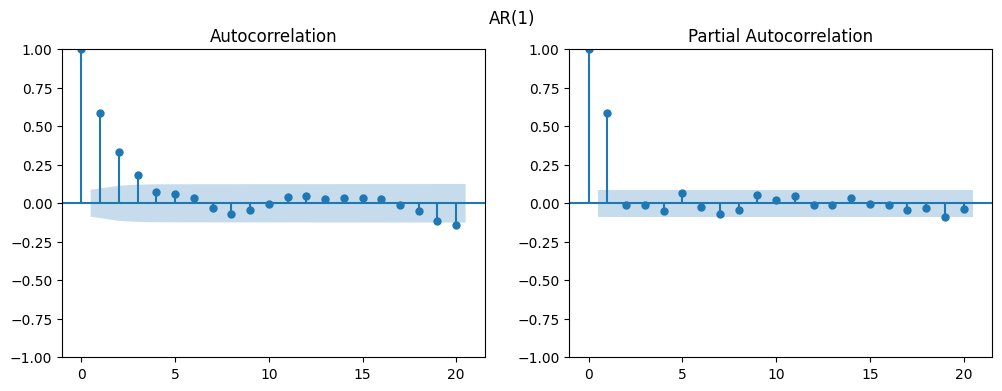

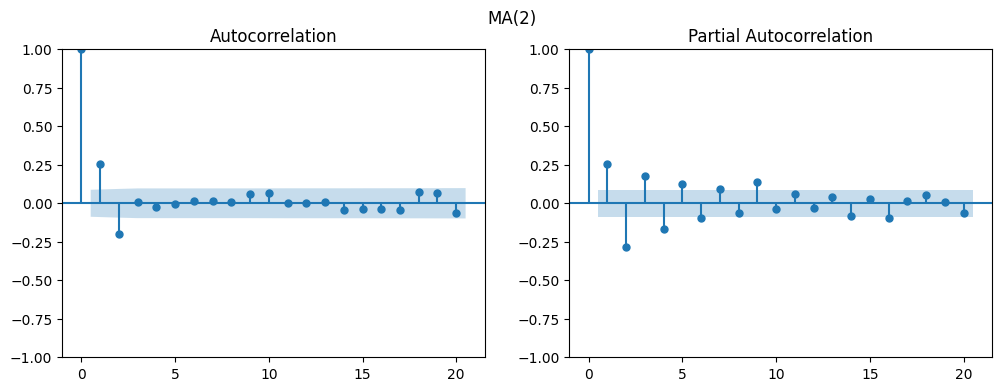

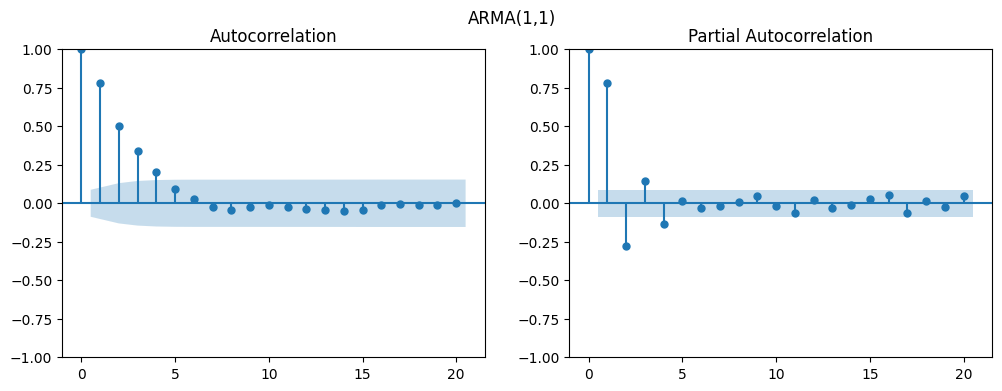

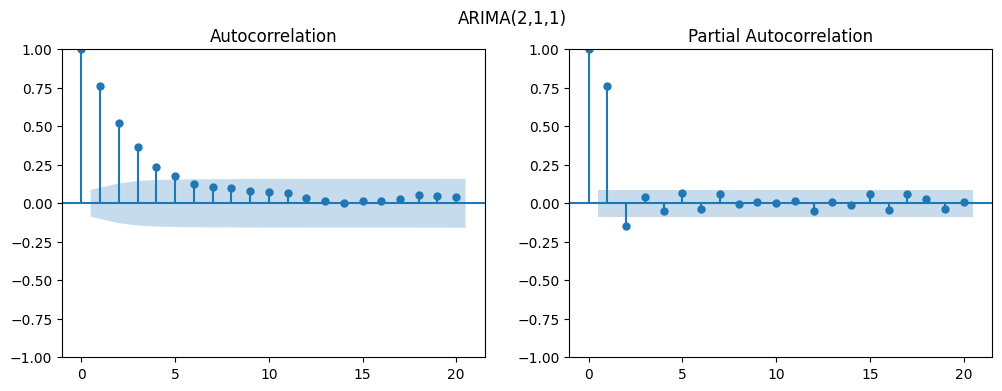

In [9]:
for name, ts in series_dict_diff.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(ts, ax=axes[0], lags=20)
    plot_pacf(ts, ax=axes[1], lags=20)
    fig.suptitle(name)
    plt.show()

In [10]:
pq_ranges = {}

for name, ts in series_dict_diff.items():
    print(f"\n--- {name} ---")
    
    acf_vals = acf(ts, nlags=10)
    pacf_vals = pacf(ts, nlags=10)
    conf = 1.96 / np.sqrt(len(ts))
    
    print(f"95% confidence bound: ±{conf:.3f}")
    print(f"{'Lag':<5} {'ACF':<10} {'PACF':<10} {'ACF sig?':<10} {'PACF sig?':<10}")
    for lag in range(1, 11):
        acf_sig = "Yes" if abs(acf_vals[lag]) > conf else "No"
        pacf_sig = "Yes" if abs(pacf_vals[lag]) > conf else "No"
        print(f"{lag:<5} {acf_vals[lag]:<10.3f} {pacf_vals[lag]:<10.3f} {acf_sig:<10} {pacf_sig:<10}")

    p_max = 0
    for lag in range(1, 11):
        if abs(pacf_vals[lag]) > conf:
            p_max = lag
        else:
            break
    
    q_max = 0
    for lag in range(1, 11):
        if abs(acf_vals[lag]) > conf:
            q_max = lag
        else:
            break

    p_end = min(p_max + 2, 6)
    q_end = min(q_max + 2, 6)
    
    p_range = range(0, p_end)
    q_range = range(0, q_end)
    
    pq_ranges[name] = {'p': p_range, 'q': q_range}
    print(f"→ p range: {list(p_range)}, q range: {list(q_range)}")


--- AR(1) ---
95% confidence bound: ±0.088
Lag   ACF        PACF       ACF sig?   PACF sig? 
1     0.585      0.586      Yes        Yes       
2     0.335      -0.012     Yes        No        
3     0.185      -0.009     Yes        No        
4     0.071      -0.048     No         No        
5     0.062      0.065      No         No        
6     0.033      -0.025     No         No        
7     -0.027     -0.068     No         No        
8     -0.070     -0.045     No         No        
9     -0.042     0.055      No         No        
10    -0.008     0.025      No         No        
→ p range: [0, 1, 2], q range: [0, 1, 2, 3, 4]

--- MA(2) ---
95% confidence bound: ±0.088
Lag   ACF        PACF       ACF sig?   PACF sig? 
1     0.257      0.258      Yes        Yes       
2     -0.201     -0.287     Yes        Yes       
3     0.010      0.177      No         Yes       
4     -0.022     -0.171     No         Yes       
5     -0.003     0.128      No         Yes       
6     0.012    

# Step 3

In [11]:
all_results = {}

for name, ts in series_dict.items():
    print(f"\n--- {name} ---")
    
    p_range = pq_ranges[name]['p']
    q_range = pq_ranges[name]['q']
    d = d_values[name]
    
    results = []
    
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(ts, order=(p, d, q))
                fit = model.fit()
                results.append({
                    'order': (p, d, q),
                    'aic': fit.aic,
                    'bic': fit.bic,
                    'model': fit
                })
                print(f"({p}, {d}, {q}) → AIC: {fit.aic:.2f}, BIC: {fit.bic:.2f}")
            except:
                print(f"({p}, {d}, {q}) → failed")
                continue
    
    all_results[name] = results


--- AR(1) ---
(0, 0, 0) → AIC: 1614.03, BIC: 1622.46
(0, 0, 1) → AIC: 1452.99, BIC: 1465.63
(0, 0, 2) → AIC: 1424.89, BIC: 1441.75
(0, 0, 3) → AIC: 1406.51, BIC: 1427.58
(0, 0, 4) → AIC: 1408.44, BIC: 1433.73
(1, 0, 0) → AIC: 1405.24, BIC: 1417.89
(1, 0, 1) → AIC: 1407.17, BIC: 1424.03
(1, 0, 2) → AIC: 1409.14, BIC: 1430.21
(1, 0, 3) → AIC: 1408.43, BIC: 1433.72
(1, 0, 4) → AIC: 1409.83, BIC: 1439.33
(2, 0, 0) → AIC: 1407.17, BIC: 1424.03
(2, 0, 1) → AIC: 1406.98, BIC: 1428.05
(2, 0, 2) → AIC: 1410.87, BIC: 1436.16
(2, 0, 3) → AIC: 1410.12, BIC: 1439.62
(2, 0, 4) → AIC: 1411.61, BIC: 1445.32

--- MA(2) ---
(0, 0, 0) → AIC: 1540.20, BIC: 1548.63
(0, 0, 1) → AIC: 1452.03, BIC: 1464.67
(0, 0, 2) → AIC: 1402.93, BIC: 1419.79
(0, 0, 3) → AIC: 1403.99, BIC: 1425.07
(1, 0, 0) → AIC: 1507.94, BIC: 1520.59
(1, 0, 1) → AIC: 1405.16, BIC: 1422.02
(1, 0, 2) → AIC: 1403.84, BIC: 1424.91
(1, 0, 3) → AIC: 1405.97, BIC: 1431.25
(2, 0, 0) → AIC: 1467.21, BIC: 1484.07
(2, 0, 1) → AIC: 1404.34, BIC: 142

In [12]:


for name in all_results:
    print(f"\n--- {name} ---")
    print(f"{'Order':<12} {'Ljung-Box':<12} {'ACF out':<10} {'BP':<12} {'Shapiro':<12} {'Pass?'}")
    
    for r in all_results[name]:
        resid = r['model'].resid
        
        lb_pval = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].values[0]
        
        acf_vals = acf(resid, nlags=10)
        conf = 1.96 / np.sqrt(len(resid))
        acf_outside = sum(abs(acf_vals[1:]) > conf)
        
        exog = np.arange(len(resid)).reshape(-1, 1)
        _, bp_pval, _, _ = het_breuschpagan(resid, sm.add_constant(exog))

        _, sw_pval = stats.shapiro(resid[:500])
        
        passed = (lb_pval > 0.05) and (acf_outside == 0) and (bp_pval > 0.05) and (sw_pval > 0.05)
        
        r['lb_pval'] = lb_pval
        r['acf_outside'] = acf_outside
        r['bp_pval'] = bp_pval
        r['sw_pval'] = sw_pval
        r['passed'] = passed
        
        status = "✅" if passed else "❌"
        print(f"{str(r['order']):<12} {lb_pval:<12.4f} {acf_outside:<10} {bp_pval:<12.4f} {sw_pval:<12.4f} {status}")


--- AR(1) ---
Order        Ljung-Box    ACF out    BP           Shapiro      Pass?
(0, 0, 0)    0.0000       3          0.0522       0.1770       ❌
(0, 0, 1)    0.0000       2          0.2334       0.0575       ❌
(0, 0, 2)    0.0053       2          0.3129       0.2830       ❌
(0, 0, 3)    0.9074       0          0.3025       0.2949       ✅
(0, 0, 4)    0.9061       0          0.3105       0.3200       ✅
(1, 0, 0)    0.6427       0          0.3052       0.3896       ✅
(1, 0, 1)    0.6579       0          0.3140       0.3791       ✅
(1, 0, 2)    0.6594       0          0.3160       0.3812       ✅
(1, 0, 3)    0.9052       0          0.3117       0.3252       ✅
(1, 0, 4)    0.9195       0          0.2944       0.3364       ✅
(2, 0, 0)    0.6583       0          0.3143       0.3789       ✅
(2, 0, 1)    0.7117       0          0.3737       0.2784       ✅
(2, 0, 2)    0.7117       0          0.3164       0.3369       ✅
(2, 0, 3)    0.9063       0          0.2947       0.2995       ✅
(2, 0,

In [13]:
best_orders = {}

for name in all_results:
    print(f"\n--- {name} ---")
    
    valid = [r for r in all_results[name] if r['passed']]
    
    print(f"Total models: {len(all_results[name])}")
    print(f"Valid models (passed diagnostics): {len(valid)}")
    
    if valid:
        best = min(valid, key=lambda x: x['aic'])
        best_orders[name] = best['order']
        print(f"Best order (by AIC): {best['order']}, AIC: {best['aic']:.2f}, BIC: {best['bic']:.2f}")
    else:
        best_orders[name] = None
        print("No valid model found")

print(f"\n--- Summary ---")
for name, order in best_orders.items():
    print(f"{name}: {order}")


--- AR(1) ---
Total models: 15
Valid models (passed diagnostics): 12
Best order (by AIC): (1, 0, 0), AIC: 1405.24, BIC: 1417.89

--- MA(2) ---
Total models: 24
Valid models (passed diagnostics): 17
Best order (by AIC): (0, 0, 2), AIC: 1402.93, BIC: 1419.79

--- ARMA(1,1) ---
Total models: 36
Valid models (passed diagnostics): 28
Best order (by AIC): (1, 0, 1), AIC: 1436.20, BIC: 1453.06

--- ARIMA(2,1,1) ---
Total models: 24
Valid models (passed diagnostics): 18
Best order (by AIC): (3, 1, 1), AIC: 1402.62, BIC: 1423.68

--- Summary ---
AR(1): (1, 0, 0)
MA(2): (0, 0, 2)
ARMA(1,1): (1, 0, 1)
ARIMA(2,1,1): (3, 1, 1)


## Rolling Z-Score Trading Strategy (Mean-Reversion)

When a time series is (weakly) stationary, its mean and variance remain roughly constant over time. This makes **rolling z-scores** a meaningful way to quantify how far the current value deviates from its recent “normal” range. A simple mean-reversion strategy is:

1.  Choose a window length $w$ (e.g. 20 days).  
2.  Compute the rolling mean  
    $$
      \mu_t = \frac{1}{w}\sum_{i=t-w+1}^{t} x_i
    $$  
    and rolling standard deviation $\sigma_t$.  
3.  Define the rolling z-score  
    $$
      z_t = \frac{x_t - \mu_t}{\sigma_t}.
    $$  
4.  Trading signals (for a long–short, zero-cost strategy):  
    - If $z_t > +\alpha$ (e.g.\ $+1$ or $+2$), the price is “too high” → **short** expecting it to revert.  
    - If $z_t < -\alpha$, the price is “too low” → **long** expecting it to revert.  
    - Exit positions when $z_t$ crosses back toward zero.

**Why it may work with stationary models**  
- Stationarity ⇒ stable mean & variance ⇒ **z-scores have a consistent interpretation**.  
- Mean-reverting processes (e.g. AR(1) with $|\phi|<1$, Ornstein–Uhlenbeck) oscillate around their long-run mean, so “extreme” $z_t$ often revert.

**Caveats**  
- Real financial prices (levels) are usually **non-stationary**, so you must difference or de-trend first (e.g.\ use returns instead of prices).  
- Returns can exhibit time-varying volatility (heteroskedasticity) → fixed-window z-scores may be misleading when regimes shift.  
- Transaction costs, slippage and regime changes can erode backtest performance.

In summary, a rolling z-score mean-reversion strategy **may** produce statistically robust signals on truly stationary, mean-reverting series—but in practice you must carefully test stationarity (and volatility stability) before trusting such signals on financial data.

## Hands-On Data: `hkutg_training_data`

All members can find the training data in the `hkutg_training_data` file (more info on our group Google Drive link: https://drive.google.com/drive/folders/1yeg0Mr9AT_-V4kIs5DOh2oDgaWl-gIGz?usp=drive_link).

This dataset contains daily price series for three “synthetic” assets:

- **STAT**  
- **MATH**  
- **COMP**  

Each of these price series was in fact generated from an underlying ARIMA model (with added noise/trend).  Your task:

1.  Load the data using pandas.  
2.  Plot each price series and look for trends or seasonality → detrend or difference as needed to achieve stationarity.  
3.  Apply stationarity tests (ADF & KPSS) and plot ACF/PACF on the pre-processed series to hypothesize appropriate \((p,d,q)\).  
4.  Fit ARIMA models via a small grid-search (or `auto_arima`) and compare the lowest-AIC orders to the true generating models.  

You’ll thereby “reverse engineer” which ARIMA processes drove STAT, MATH and COMP. In general, this is difficult to do. If you are unable to get reliable results, do not worry too much.

---

## Sample Results

Please refer to the `sample_result.png` file in our Google Drive (in the group folder). It precisely shows the filtered STAT price series result.  
Compare your notebook’s figures and test results to this sample image to verify that your analysis steps are correct.

In [14]:
# TODO: Conduct appropriate detrending or filtering of the time series to end up with a stationary distribution.
# (Optional): Use the relevant backtesting framework in the 'HKU Trading Group Quant Research Assessment' folder 
#             on the Google Drive and conduct the backtest.

Food for thought: 

The statistical relationships will only hold until they do not (which is generally hard to determine). Similarly, cointegration (check Project 3 Jupyter Notebook) will hold until they do not.  

Therefore, it may be good to have a good mix of quantitative reasoning and financial awareness (e.g. macro news, idiosyncratic movements) before making such decisions. It is generally hard to believe that any price series in the market has constant variance (as assumed for starionary processes).

What can we do then?